Importing libraries

In [1]:
!echo !pip install matplotlib

!pip install matplotlib


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import requests
import time

2024-06-27 22:36:59.994604: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 22:36:59.994665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 22:36:59.997387: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-27 22:37:00.026465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 22:37:01.316952: W tensorflow/compiler/tf2

### Creating data parser

In [3]:
DATABASE_URL = "https://crossoutdb.com/"
DATA_ID = 7

def getJSONDataOfItemByID(fileID: int):
    id = fileID
    path = 'data/item/all/'
    url = DATABASE_URL + path + str(id)
    requests_file = requests.get(url)
    jsonData = requests_file.json()['Data']
    return jsonData


JSONdataOfItemWithID = getJSONDataOfItemByID(DATA_ID)

In [4]:
def convertOneItemDataToDataframeFromJson(jsonData):
    jsonDataCopy_1 = jsonData
    
    def getArrayDataFromJson(jsonData):
        jsonDataCopy = jsonData
        
        numberOfColumns = len(jsonDataCopy)
        numberOfRows = len(jsonDataCopy[0])

        # json file has shape of 4 "columns" with the same lenght. 
        # Each column is represented by time (like key) and its value.

        arrayData = []
        for row in range(numberOfRows):
            sellPrice = jsonDataCopy[0][row][1]
            buyPrice = jsonDataCopy[1][row][1]
            sellOffers = jsonDataCopy[2][row][1]
            buyOrders = jsonDataCopy[3][row][1]

            # key / time --- UNIX_TIMESTAMP
            dateTime = jsonDataCopy[0][row][0]

            rowData = [dateTime, sellPrice, buyPrice, sellOffers, buyOrders]
            arrayData.append(rowData)
        return arrayData
    
    numpyArrayData = np.array(getArrayDataFromJson(jsonDataCopy_1))
    df = pd.DataFrame(numpyArrayData, columns=["Date Time", "Sell Price", "Buy Price", "Sell Offers", "Buy Orders"])
    return df

In [5]:
data_df = convertOneItemDataToDataframeFromJson(JSONdataOfItemWithID)
print(data_df.head())

      Date Time  Sell Price  Buy Price  Sell Offers  Buy Orders
0  1.711141e+12       38.79      32.22         43.0        78.0
1  1.711145e+12       38.99      32.21         39.0        75.0
2  1.711148e+12       39.48      32.21         32.0        72.0
3  1.711152e+12       38.39      31.75         35.0        67.0
4  1.711156e+12       39.00      31.73         32.0        65.0


## Creating plot form data

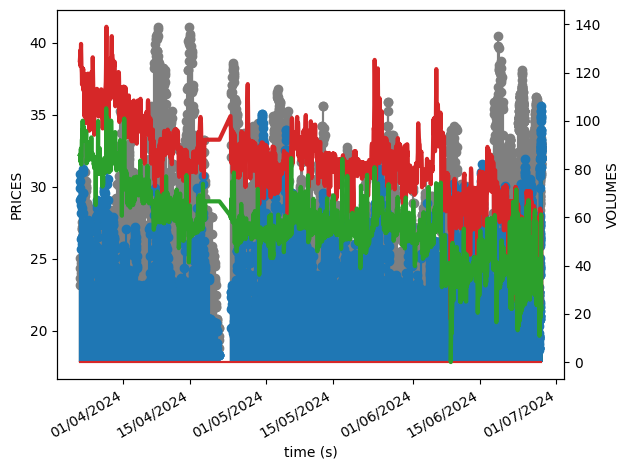

In [6]:
import matplotlib.dates as mdates

def plotData(data: pd.core.frame.DataFrame):
    dateTime = data["Date Time"]
    sellPrice = data["Sell Price"]
    buyPrice = data["Buy Price"]
    sellOffers = data["Sell Offers"]
    buyOrders = data["Buy Orders"]
    
    def formatData(data):
        floatData = data.apply(lambda x: float(x))
        dataArray = floatData.to_numpy()
        return dataArray
    
    dateTime = pd.to_datetime(dateTime, unit='ms')
    sellPrice = formatData(sellPrice)
    buyPrice = formatData(buyPrice)
    sellOffers = formatData(sellOffers)
    buyOrders = formatData(buyOrders)
    
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('PRICES')
    ax1.plot(dateTime, sellPrice, color='tab:red', linewidth=3)
    ax1.plot(dateTime, buyPrice, color='tab:green', linewidth=3)
    ax1.tick_params(axis='y')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylabel('VOLUMES')  # we already handled the x-label with ax1
    ax2.stem(dateTime, sellOffers, linefmt='tab:grey')
    ax2.stem(dateTime, buyOrders, linefmt='tab:blue')
    ax2.tick_params(axis='y')
    
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
    fig.autofmt_xdate()  # Rotation of date labels

    ax1.set_zorder(2)
    ax2.set_zorder(1)
    ax1.patch.set_visible(False)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    
plotData(data_df)

#### Market history is too large. We will operrate on last week history. So lets create a trim function

In [7]:
from datetime import timedelta

def trimDataFromTheLastWeek(data: pd.core.frame.DataFrame):
    WEEK_SECONDS = 604800
    
    dataCopy = data.copy()
    
    dataCopy['Temp Date Time'] = pd.to_datetime(dataCopy['Date Time'], unit='ms')

    lastTimestamp = dataCopy['Temp Date Time'].iloc[-1]
    
    oneWeekAgo = lastTimestamp  - timedelta(weeks=1)
    
    dfLastWeek = dataCopy[dataCopy['Temp Date Time'] >= oneWeekAgo]
    
    dfLastWeek.reset_index(drop=True, inplace=True)
    
    dfLastWeek = dfLastWeek.drop(columns=['Temp Date Time'])
    
    return dfLastWeek

lastWeekData = trimDataFromTheLastWeek(data_df)
print(lastWeekData)

         Date Time  Sell Price  Buy Price  Sell Offers  Buy Orders
0     1.718916e+12       27.78      24.01         88.0        35.0
1     1.718916e+12       27.78      24.02         86.0        37.0
2     1.718917e+12       27.78      24.01         88.0        34.0
3     1.718917e+12       27.78      24.01         86.0        34.0
4     1.718917e+12       28.00      24.01         86.0        34.0
...            ...         ...        ...          ...         ...
1935  1.719519e+12       27.99      21.51         82.0        96.0
1936  1.719520e+12       28.00      21.56         81.0       100.0
1937  1.719520e+12       25.00      21.60         85.0       104.0
1938  1.719520e+12       25.00      21.60         85.0       104.0
1939  1.719520e+12       22.00      21.62         85.0       101.0

[1940 rows x 5 columns]


## Now we can look at plot

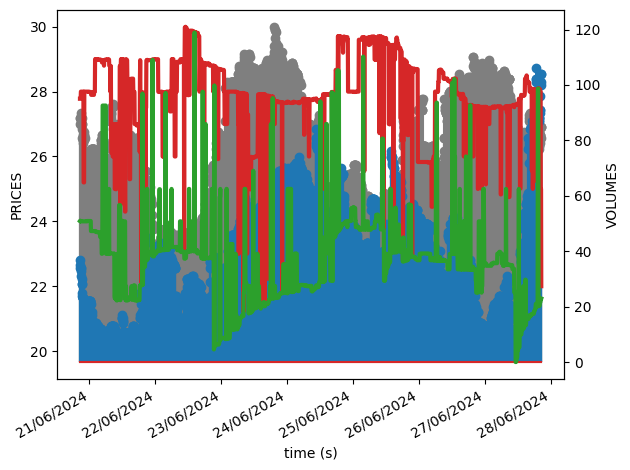

In [8]:
plotData(lastWeekData)

# Let's start do some neural networking

In [9]:
main_df = lastWeekData.copy()
main_df.set_index("Date Time", inplace = True)
print(main_df)

              Sell Price  Buy Price  Sell Offers  Buy Orders
Date Time                                                   
1.718916e+12       27.78      24.01         88.0        35.0
1.718916e+12       27.78      24.02         86.0        37.0
1.718917e+12       27.78      24.01         88.0        34.0
1.718917e+12       27.78      24.01         86.0        34.0
1.718917e+12       28.00      24.01         86.0        34.0
...                  ...        ...          ...         ...
1.719519e+12       27.99      21.51         82.0        96.0
1.719520e+12       28.00      21.56         81.0       100.0
1.719520e+12       25.00      21.60         85.0       104.0
1.719520e+12       25.00      21.60         85.0       104.0
1.719520e+12       22.00      21.62         85.0       101.0

[1940 rows x 4 columns]


In [10]:
SEQ_LEN = 10
FUTURE_PERIOD_PREDICT = 2

def classifyBySellPrice(current, future):
    if float(future) >= float(current):
        return 1
    else:
        return 0

In [11]:
main_df['future Sell Price'] = main_df["Sell Price"].shift(-FUTURE_PERIOD_PREDICT)
print(main_df.head())

              Sell Price  Buy Price  Sell Offers  Buy Orders  \
Date Time                                                      
1.718916e+12       27.78      24.01         88.0        35.0   
1.718916e+12       27.78      24.02         86.0        37.0   
1.718917e+12       27.78      24.01         88.0        34.0   
1.718917e+12       27.78      24.01         86.0        34.0   
1.718917e+12       28.00      24.01         86.0        34.0   

              future Sell Price  
Date Time                        
1.718916e+12              27.78  
1.718916e+12              27.78  
1.718917e+12              28.00  
1.718917e+12              28.00  
1.718917e+12              28.00  


In [12]:
main_df['target'] = list(map(classifyBySellPrice, main_df["Sell Price"], main_df["future Sell Price"]))
print(main_df.head())

              Sell Price  Buy Price  Sell Offers  Buy Orders  \
Date Time                                                      
1.718916e+12       27.78      24.01         88.0        35.0   
1.718916e+12       27.78      24.02         86.0        37.0   
1.718917e+12       27.78      24.01         88.0        34.0   
1.718917e+12       27.78      24.01         86.0        34.0   
1.718917e+12       28.00      24.01         86.0        34.0   

              future Sell Price  target  
Date Time                                
1.718916e+12              27.78       1  
1.718916e+12              27.78       1  
1.718917e+12              28.00       1  
1.718917e+12              28.00       1  
1.718917e+12              28.00       1  


In [13]:
main_df.dropna(inplace=True)

times = sorted(main_df.index.values)
last_5pct_index = int(0.05*len(times))
print(last_5pct_index)

last_5pct = times[-last_5pct_index]
print(last_5pct)

96
1719491100000.0


In [14]:
validation_main_df = main_df[(main_df.index >= last_5pct)]
main_df = main_df[(main_df.index < last_5pct)]

In [15]:
from sklearn import preprocessing
from collections import deque
import random

def preprocess_df(df):
    df = df.drop('future Sell Price', axis=1)
    
    for col in df.columns:
        if col != 'target':
            df[col] = df[col].pct_change()
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)
    
    df.dropna(inplace=True)
    
    sequencial_data = []
    prev_days = deque(maxlen=SEQ_LEN)
    
    for i in df.values:                          #here we lose date time
        prev_days.append([n for n in i[:-1]])
        if len(prev_days) == SEQ_LEN:
            sequencial_data.append([np.array(prev_days), i[-1]])
    
    random.shuffle(sequencial_data)
    
    
    
    we_buy_this = []
    we_do_not_buy_this = []
    
    for seq, target in sequencial_data:
        if target == 0:
            we_do_not_buy_this.append([seq, target])
        elif target == 1:
            we_buy_this.append([seq, target])
    
    lower = min(len(we_buy_this), len(we_do_not_buy_this))
    
    we_buy_this = we_buy_this[:lower];
    we_do_not_buy_this = we_do_not_buy_this[:lower]
    
    sequencial_data = we_buy_this + we_do_not_buy_this
    random.shuffle(sequencial_data)
    
    X = []
    y = []
    
    for seq, target in sequencial_data:
        X.append(seq)
        y.append(target)
        
    return np.array(X), np.array(y)

In [16]:
train_x, train_y = preprocess_df(main_df)
validation_x, validation_y = preprocess_df(validation_main_df)

print(len(train_x))
print(train_x.shape)

1032
(1032, 10, 4)


In [17]:
import time
EPOCHS = 10
BATCH_SIZE = 32

NAME = f"{DATA_ID}-ID-{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PREDICT-{int(time.time())}"

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [23]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))

model.add((Dense(1, activation='sigmoid')))


opt = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=1e-6)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=opt,
             metrics=['accuracy'])


tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "RNN_Final-{epoch:02d}-{val_loss:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')) # saves only the best ones



In [24]:
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    callbacks=[tensorboard, checkpoint],
)

Epoch 1/10
31/33 [===========================>..] - ETA: 0s - loss: nan - accuracy: 0.4919INFO:tensorflow:Assets written to: models/RNN_Final-01-nan.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-01-nan.model/assets


33/33 [==============================] - 12s 255ms/step - loss: nan - accuracy: 0.4981 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/10
31/33 [===========================>..] - ETA: 0s - loss: nan - accuracy: 0.4980INFO:tensorflow:Assets written to: models/RNN_Final-02-nan.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-02-nan.model/assets


33/33 [==============================] - 8s 233ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/10
32/33 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.4980INFO:tensorflow:Assets written to: models/RNN_Final-03-nan.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-03-nan.model/assets


33/33 [==============================] - 8s 247ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/10
32/33 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.5000INFO:tensorflow:Assets written to: models/RNN_Final-04-nan.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-04-nan.model/assets


33/33 [==============================] - 8s 237ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 5/10
32/33 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.4980INFO:tensorflow:Assets written to: models/RNN_Final-05-nan.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-05-nan.model/assets


33/33 [==============================] - 8s 246ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 6/10
33/33 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5000INFO:tensorflow:Assets written to: models/RNN_Final-06-nan.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-06-nan.model/assets


33/33 [==============================] - 8s 241ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 7/10
32/33 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.5000INFO:tensorflow:Assets written to: models/RNN_Final-07-nan.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-07-nan.model/assets


33/33 [==============================] - 7s 232ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 8/10
33/33 [==============================] - ETA: 0s - loss: nan - accuracy: 0.5000INFO:tensorflow:Assets written to: models/RNN_Final-08-nan.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-08-nan.model/assets


33/33 [==============================] - 8s 241ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 9/10
32/33 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.5039INFO:tensorflow:Assets written to: models/RNN_Final-09-nan.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-09-nan.model/assets


33/33 [==============================] - 8s 241ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000
Epoch 10/10
31/33 [===========================>..] - ETA: 0s - loss: nan - accuracy: 0.5050INFO:tensorflow:Assets written to: models/RNN_Final-10-nan.model/assets


INFO:tensorflow:Assets written to: models/RNN_Final-10-nan.model/assets


33/33 [==============================] - 8s 241ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5000


Traceback (most recent call last):
  File "/home/galezza/anaconda3/envs/py310/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/home/galezza/anaconda3/envs/py310/lib/python3.10/site-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/home/galezza/anaconda3/envs/py310/lib/python3.10/site-packages/tensorboard/default.py", line 32, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/home/galezza/anaconda3/envs/py310/lib/python3.10/site-packages/tensorboard/plugins/audio/audio_plugin.py", line 20, in <module>
    from werkzeug import wrappers
  File "/home/galezza/anaconda3/envs/py310/lib/python3.10/site-packages/werkzeug/__init__.py", line 5, in <module>
    from .serving import run_simple as run_simple
  File "/home/galezza/anaconda3/envs/py310/lib/python3.10/site-packages/werkzeug/serving.py", line 35, in <module>
    from .exceptions import InternalServerError
  File "/home/galez